In [1]:
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import f1_score, accuracy_score
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoTokenizer
from datasets import load_dataset

#### Data:

In [2]:
#Loading the dataset and tokenizer
emotions_dataset = load_dataset('emotion')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize the dataset
def tokenize_dataset(batch_data):
    return tokenizer(batch_data['text'], padding=True, truncation=True)

emotions_tokenized = emotions_dataset.map(tokenize_dataset, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

#### Model:

In [4]:
device= "cuda" if torch.cuda.is_available() else "cpu"
num_of_labels= 6

model= AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_of_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining the performance metrics that will be use to access the performance of the model, considering F1 and accuracy for now:

In [5]:
def compute_metrices(predictions):
    print('predictions:', predictions)
    labels= predictions.label_ids
    preds= predictions.predictions.argmax(-1)
    f1= f1_score(labels, preds, average="weighted")
    acc= accuracy_score(labels, preds)
    return {
        "f1": f1,
        "accuracy": acc
    }

In [6]:
from huggingface_hub import notebook_login
notebook_login()

### Training:

In [8]:
batch_size= 64

#we have to log for every batch
logging_steps= len(emotions_tokenized["train"]) // batch_size
model_name= "bert-base-uncased_finetured-emotions"

training_args= TrainingArguments(
    output_dir= model_name,
    num_train_epochs= 2,
    learning_rate= 2e-5,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    weight_decay= 0.01,
    evaluation_strategy= "epoch",
    disable_tqdm= False,
    logging_steps= logging_steps,
    push_to_hub= True,
    log_level= "error",
)

In [9]:
trainer= Trainer(
    model= model,
    compute_metrics= compute_metrices,
    train_dataset= emotions_tokenized["train"],
    eval_dataset= emotions_tokenized["validation"],
    tokenizer= tokenizer,
)
trainer.train()

Step,Training Loss
500,0.708800
1000,0.329200
1500,0.275700
2000,0.215100
2500,0.158800
3000,0.159000
3500,0.156900
4000,0.144600
4500,0.117600
5000,0.113500


TrainOutput(global_step=6000, training_loss=0.21475672849019367, metrics={'train_runtime': 1131.1882, 'train_samples_per_second': 42.433, 'train_steps_per_second': 5.304, 'total_flos': 1970665688486592.0, 'train_loss': 0.21475672849019367, 'epoch': 3.0})

#### Evaluation:

In [28]:
print(emotions_tokenized["validation"])

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


In [12]:
predictions_out= trainer.predict(emotions_tokenized["validation"])
predictions_out.metrics

predictions: <transformers.trainer_utils.EvalPrediction object at 0x79220007be80>


{'test_loss': 0.2027212530374527,
 'test_f1': 0.937342154325144,
 'test_accuracy': 0.9375,
 'test_runtime': 10.5714,
 'test_samples_per_second': 189.189,
 'test_steps_per_second': 23.649}

In [13]:
import numpy as np
y_preds= np.argmax(predictions_out.predictions, axis= 1)


In [23]:
labels = emotions_dataset["train"].features["label"].names
y_valid= np.array(emotions_tokenized["validation"]["label"])
y_preds[:30]

array([0, 0, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1, 0, 0, 2, 1, 4, 0,
       1, 0, 0, 0, 2, 2, 0, 0])

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()



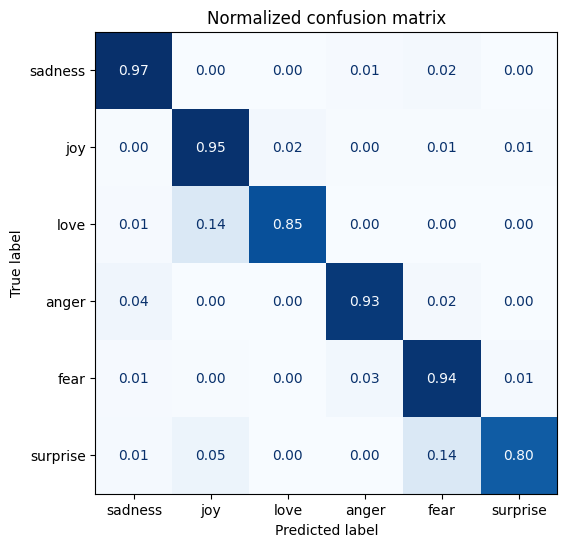

In [24]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [25]:
test_sentence= "I am very out of mind right now!"
test_sentence_tokenized= tokenizer(test_sentence, return_tensors="pt")
test_sentence_tokenized

{'input_ids': tensor([[ 101, 1045, 2572, 2200, 2041, 1997, 2568, 2157, 2085,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [30]:
test_sentence_tokenized.to(device)

predictions= model(**test_sentence_tokenized)
predictions

SequenceClassifierOutput(loss=None, logits=tensor([[-0.7934,  0.5074, -3.6200,  4.4030,  1.1728, -2.3722]],
       device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [44]:
y_preds= predictions['logits']
index_labels= y_preds.argmax()
print(f"Prediction for {test_sentence} is: ", labels[index_labels])

Prediction for I am very out of mind right now! is:  anger


### Saving and Sharing the model:

In [45]:
trainer.push_to_hub(commit_message="Distilbert Training completed on emotions dataset")

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

events.out.tfevents.1727606279.35f993249938.678.0:   0%|          | 0.00/8.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/usmanyaqoob/tmp_trainer/commit/095b3a6b3b72229a168626e87ecb2b9d570b81c7', commit_message='Distilbert Training completed on emotions dataset', commit_description='', oid='095b3a6b3b72229a168626e87ecb2b9d570b81c7', pr_url=None, pr_revision=None, pr_num=None)